## Exercício 1 (2 pontos)

a) Qual a importância de termos modelos que são interpretáveis? 

Compare também as vantagens de cada uma dos casos abaixo: (i) o uso de modelos simples interpretáveis e (ii) o uso de modelos complexos complementados por ferramentas de interpretabilidade.



***Resposta:*** Modelos interpretáveis são importantes para entender os motivos que levaram o modelo a chegar naquelas predições, o que pode ajudar a entender o domínio dos dados em que o modelo está inserido, avaliar se os critérios do modelo são coerentes com a realidade e se necessário, ajustar o modelo com base na avaliação.

No caso (i) como modelos simples interpretáveis são mais fáceis de entender o modelo e seus resultados porque esse processo tende a ser mais direto, e essa maior liberdade pode ser essencial para encontrar um maior ajuste aos dados quando eles também possuem relações simples. Porém nem todos os dados possuem relações que podem ser modeladas de forma simples e interpretável, o que pode levar a interpretações erradas ou nenhuma informação importante analisando apenas o modelo.

Já no caso (ii) a combinação tem o potencial de encontrar características e relações avançadas nos dados que não são determinadas no caso (i), o que também pode ser essencial para encontrar um maior ajuste aos dados quando as relações também são complexas. Porém as possibilidades de auditar o modelo ou tirar ideias sobre o domínio estarem limitadas ao que as ferramentas podem informar, que nem sempre podem ajudar a determinar as ações que levam a um maior ajuste.

b) Explique com suas palavras o que são os valores Shapley e qual a diferença com os valores SHAP. 

Caso a explicação da aula não seja suficiente, o melhor é consultar o livro https://christophm.github.io/interpretable-ml-book/. 

***Resposta:*** Os Valores Shapley indicam como dividir a contribuição das variáveis para a predição com base no resultado de coalizões (predições que possuem algumas variáveis sempre em comum para avaliar o impacto da mudança das demais), enquanto os valores SHAP (Shapley Additive Explanations) usam os valores Shapley para explicar o efeito das variáveis em cada predição. Os valores SHAP dependem do modelo e podem ser agregados de diferentes formas para entender de diferentes formas como os preditores contribuem para obter a resposta.

c) Explique o que é o k-means e como ele consegue agrupar exemplos similares em grupos, usando uma linguagem que um jovem sem formação matemática consiga entender.

***Resposta:*** K-means consegue agrupar exemplos similares em grupos da seguinte forma. Dado um conjunto de exemplos:

1. Inicialmente todos os exemplos são divididos em K grupos aleatoriamente.
2. É escolhido o exemplo com mais características em comum com os outros exemplos do seu grupo (chamado de centróide) e cada exemplo é movido para o grupo que tem o centróide mais parecido com esse exemplo.
3. O passo anterior se repete enquanto os exemplos mudarem de grupo ao executar esse passo.

---
# Parte 2 - Prática

Nos exercícios abaixo, vocês usarão um conjunto de dados de diabetis na India. A lista de preditores e valores está no link abaixo:

https://www.kaggle.com/code/parulpandey/intrepreting-machine-learning-models/data?select=diabetes.csv

**Importante:** Após ler o DataFrame do CSV, não esqueça de retirar a resposta y do DataFrame. Caso contrário seus modelos sempre acertarão a predição :-)

Nesta primeira fase da tarefa, você ***não*** deve normalizar os seus dados com o StandardScaler. Os dados normalizados são mais difíceis de interpretar, pois preditores como idade são transformados em números positivos e negativos próximos de zero. Além disso, os métodos que utilizaremos funcionam bem com os valores não normalizados.

Os comandos abaixo importam parte das classes que utilizaremos e lê o arquivo diabetes.csv do seu computador:

```
!pip install shap

from sklearn.model_selection import train_test_split
import xgboost
import shap
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_validate

from google.colab import files
uploaded = files.upload()
```

In [45]:
import warnings
warnings.filterwarnings('ignore')

%pip install shap

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["figure.autolayout"] = True

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_validate

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

import shap
from sklearn.inspection import PartialDependenceDisplay

shap.initjs()

from IPython.display import clear_output
clear_output()

---
## Exercício 2: (2 pontos)

a) Leia os dados do arquivo `diabetes.csv`, que contém 100 exemplos de execuções e realize a classificação utilizando os classificadores Regressão Logística e XGBoost. 

No caso do XGBoost, utilize a interface do Scikit-learn, e configure-o para gerar 100 árvores de profundidade máxima 4.

1. Treine os modelos em um conjunto de treino com 80% dos dados e avalie seu desempenho sobre os dados restantes (conjunto de teste). Gere as métricas acurácia, precisão, recall e AUC da curva ROC.

2. Discuta os resultados obtidos, comparando as métricas dos 2 modelos.

In [2]:
df = pd.read_csv('diabetes.csv')

y = df['Outcome']
X = df.drop('Outcome', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
def train_model(model, X, y, show=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_pred, y_test)
    pre = precision_score(y_pred, y_test)
    rec = recall_score(y_pred, y_test)
    roc = roc_auc_score(y_pred, y_test)
    
    if show:
        print(
            f'Model: {model.__class__.__name__}\n'
            f'Accuracy: {acc:.2%}\n'
            f'Precision: {pre:.2%}\n'
            f'Recall: {rec:.2%}\n'
            f'ROC AUC: {roc:.2%}\n'
        )
    
    return acc, pre, rec, roc

In [4]:
lr = LogisticRegression(solver='newton-cg')
train_model(lr, X, y)

xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=4, eval_metric='logloss', use_label_encoder=False)
_ = train_model(xgb, X, y)

Model: LogisticRegression
Accuracy: 74.68%
Precision: 67.27%
Recall: 63.79%
ROC AUC: 72.52%

Model: XGBClassifier
Accuracy: 68.18%
Precision: 67.27%
Recall: 54.41%
ROC AUC: 66.74%



***Discussão:*** A Regressão Logística obteve resultados melhores em todas as métricas para esse conjunto de treino. Como as árvores com Gradient Boosting são modelos muito mais flexíveis que a Regressão Logística é possível que o conjunto de treino não seja grande ou variado o suficiente para treinar de forma ajustada o segundo, o levando a sofrer de variância excessiva.

b) Faça agora os gráficos de dependência parcial para o conjunto de teste na Regressão Logística e XGBoost. 

Para facilitar a visualização, gere conjuntos de gráficos, usando variações do comando abaixo:
```
PartialDependenceDisplay.from_estimator(lr, X_test, X.columns[0:3])
plt.show()
```

Interprete os gráficos de PDP para cada variável e discuta o que você consegue extrair de cada uma delas.

Compare também os PDPs da Regressão Logística com o XGBoost. Como os gráficos diferem e por que existe esta diferença?

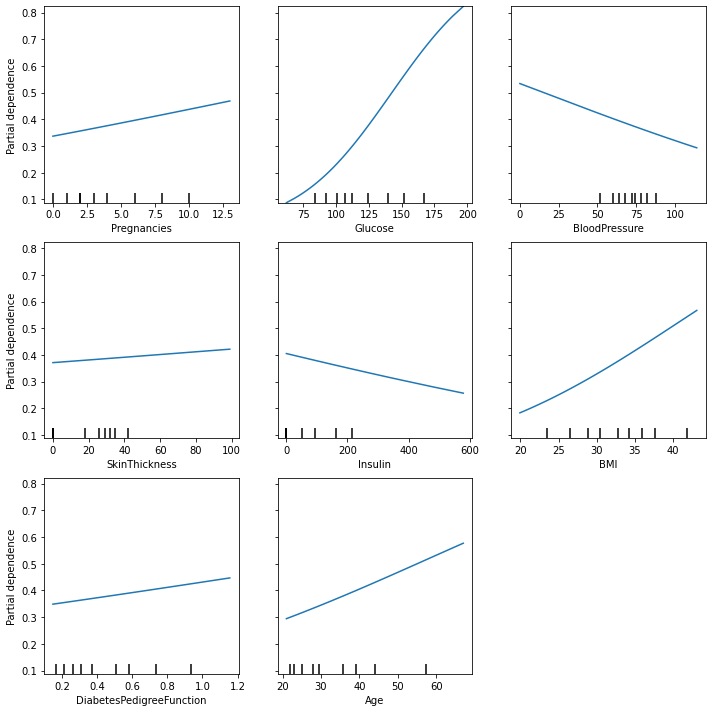

In [5]:
_ = PartialDependenceDisplay.from_estimator(lr, X_test, X_test.columns)

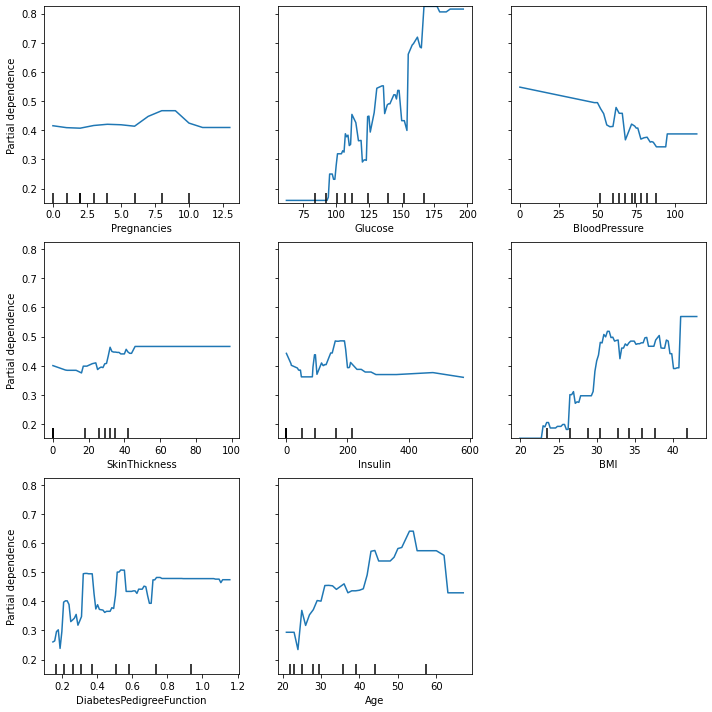

In [6]:
_ = PartialDependenceDisplay.from_estimator(xgb, X_test, X_test.columns)

***Interpretação dos PDPs:***

* **LR**: Os PDPs indicam individualmente, a regressão logística tende a classificar positivamente os exemplos fortemente a partir do aumento em `Glucose`, moderadamente a partir do aumento em `Age`, `BMI` e na redução em `BloodPressure` e `Insulin` e o aumento nos demais preditores aumenta a probabilidade mas de forma mais fraca que os demais preditores.

* **XGB**: Avaliando os casos onde o modelo tende a classificar os exemplos positivamente, aumentos em `Glucose` são indicadores fortes, bem como de forma moderada a redução de `BloodPressure`, e quando `Pregnancies` $\approx 8$, `Age` $\approx 55$, `Insulin` $\approx 200$ e `BMI` > 40.

***Comparação dos PDPs do 2 modelos:*** A relação com o aumento / redução é parecido nos dois PDPs, o que é uma evidência para uma relação intrínseca dos dados. Enquanto o PDP da LR identificou mais facilmente a impacto que o aumento / redução nas variáveis causa na predição, o PDP do XGB mostra as regiões que são mais impactantes para a predição.

---
## Exercício 3: (2 pontos)

Faremos agora a interpretação dos dados utilizando os SHAP values:

a) Usando o `TreeExplainer` com o modelo treinado no XGBoost, gere um summary_plot dos preditores. Você pode usar todos os dados X para gerar as explicações.

Em seguida, discuta o gráfico gerado, focando nos seguitnes pontos: (i) Quais os 3 preditores mais importantes? (ii) Como os valores destes preditores influenciam a classe predita?

In [7]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

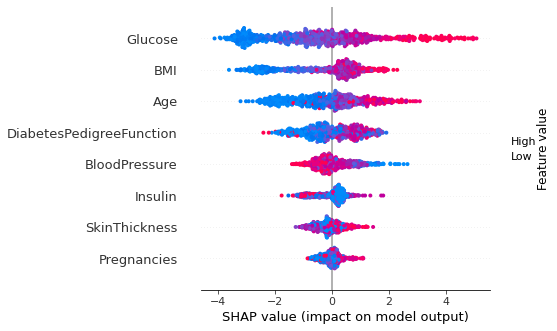

In [8]:
shap.summary_plot(shap_values, X)

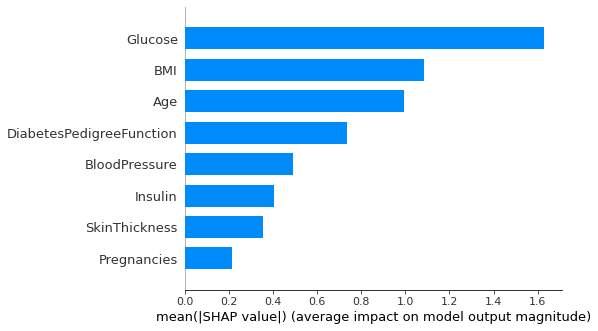

In [9]:
shap.summary_plot(shap_values, X, plot_type='bar')

***Discussão:***
(i) As variáveis mais importantes aparentam ser `Glucose`, `BMI`, `Age`, com base na sumarização.

(ii) O aumento em `Glucose`, `BMI`, e `Age` aparentam aumentar diretamente a chance do paciente possuir diabetes.

b) Gera agora os `dependence_plot` para cada variável com relação ao SHAP value. Em seguida, na seção Discussão, compare os gráficos obtidos com os PDP gerados no exercício anterior.

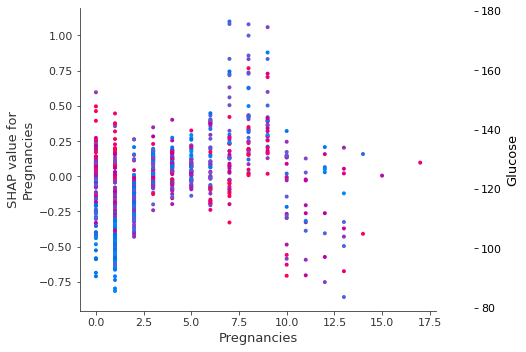

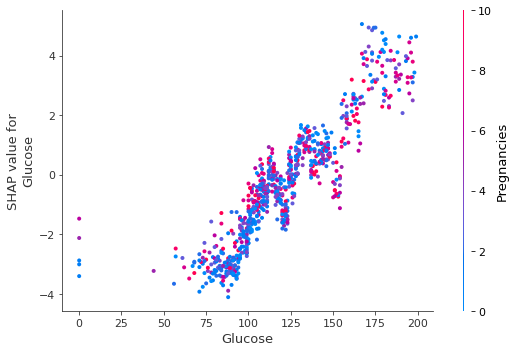

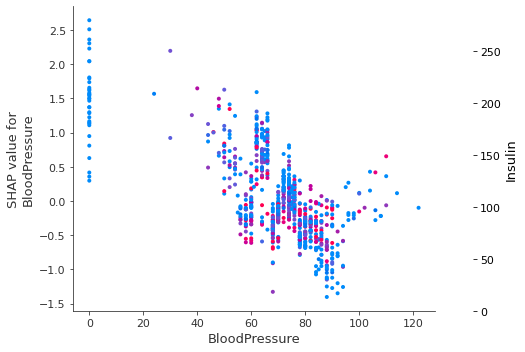

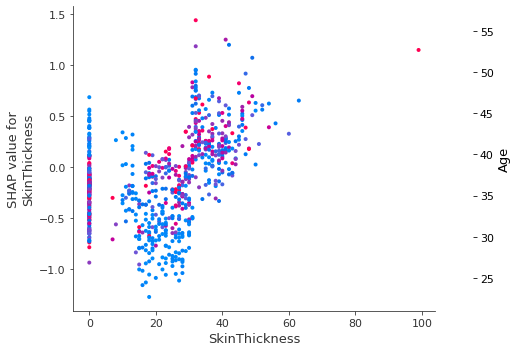

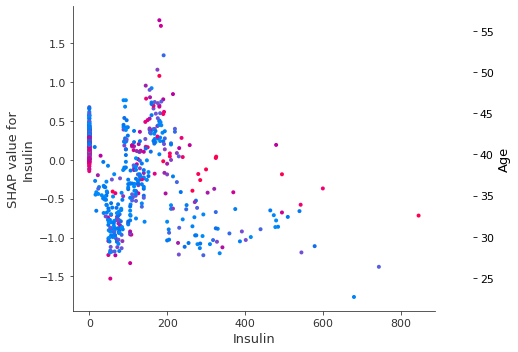

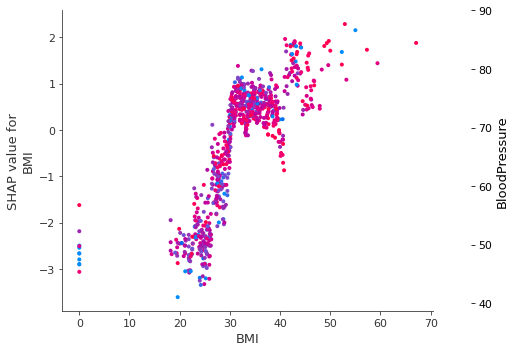

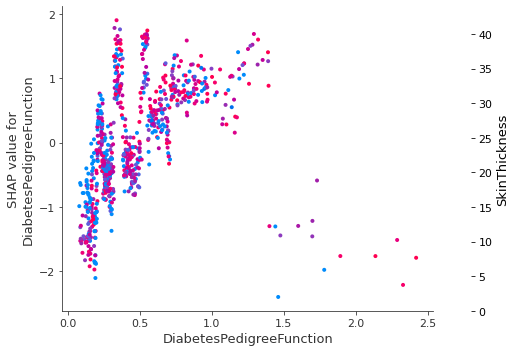

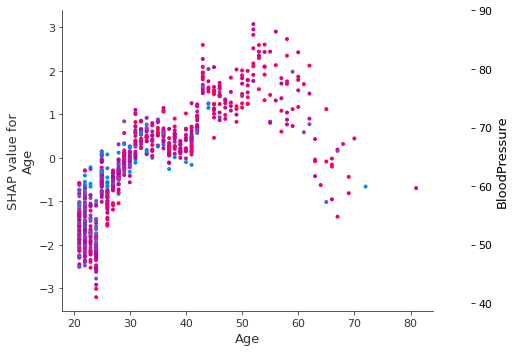

In [10]:
for name in X.columns:
    shap.dependence_plot(
        name,
        shap_values,
        X,
        display_features=X
    )

***Discussão:*** Enquanto `BMI` e `Age` possuem o mesmo comportamento notado no item anterior, o aumento em `Glucose` não aparenta ser tão fortemente proporcional como indicado anteriormente (existem muitos valores com baixa probabilidade de diabetes e alto valor em `Glucose`), o que pode indicar que a relação com o aumento dessa variável dependa da interação com outra variável independente.

c) Faremos agora a análise dos `force_plot` para entendermos as decisões individuais do modelo. Procure, dentre os exemplos, um caso onde a probabilidade de diabetes é alta, um onde é baixa, e outra onde está na média. Para cada um destes casos, gere o force plot. Em seguida, tente interpretar os force plots e quais as explicações que ele fornece. 

In [47]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)

In [69]:
def force_plot_by_index(explainer, shap_values, X, index):
    shap.force_plot(explainer.expected_value, shap_values[index, :], X.iloc[index, :], matplotlib=True)

**Probabilidade alta**

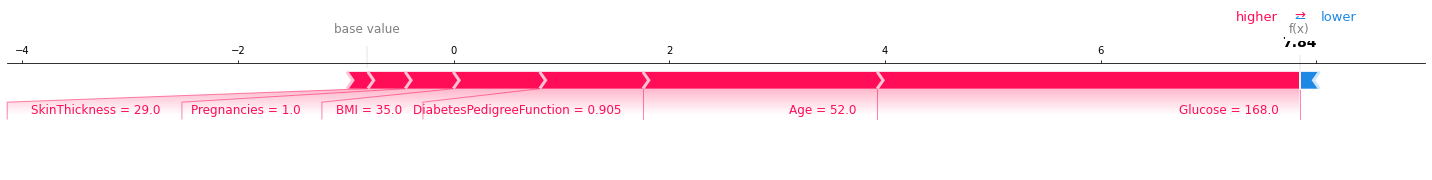

In [70]:
force_plot_by_index(explainer, shap_values, X, 702)

**Probabilidade baixa**

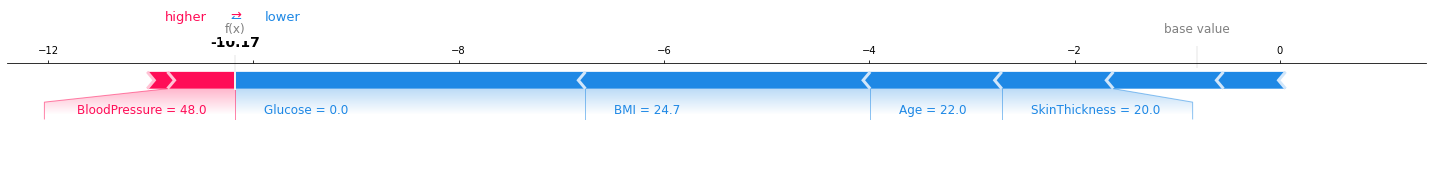

In [58]:
force_plot_by_index(explainer, shap_values, X, 75)

**Probabilidade média**

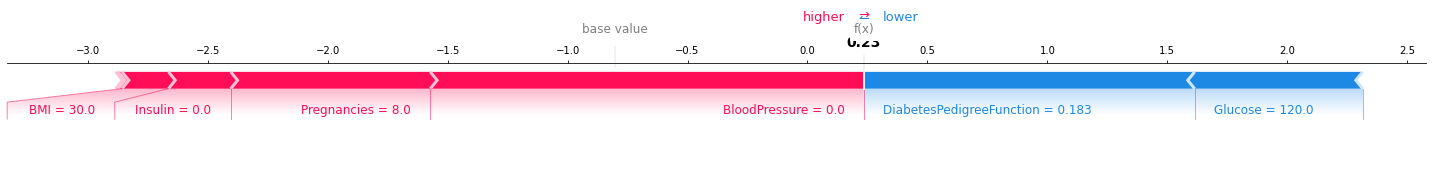

In [59]:
force_plot_by_index(explainer, shap_values, X, 468)

***Discussão:*** Além das conclusões tiradas anteriormente sobre `BMI`, `Age` e `Glucose`, no caso onde as três variáveis não eram notavelmente importantes, as duas variáveis de maior importância foram `BloodPressure` com valor baixo, que contribuiu para uma predição positiva e `DiabetesPedigreeFunction` com valor baixo, que contribuiu para uma predição negativa.

---
## Exercício 4: (2 pontos)

Faremos agora uma análise dos dados usando PCA e k-Means.

***Importante:*** para o PCA e k-means funcionarem adequadamente, é essencial fazer a normalização dos preditores, pois cada um deles está em uma escala diferente.

a) Calcule as primeira e segunda componentes do PCA utilizando os dados de *treino*. Em seguida, gere 2 gráficos: (i) contendo no eixo X a primeira componente do PCA e no eixo Y a classificação (0 ou 1), e (ii) contendos nos eixos X e Y as primeira e segunda componentes, e com a cor indicando a classe.

Baseados nos resultados gerados, discuta se seria possível fazer a separação das 2 classes a partir das primeiras e segundas componentes.

In [14]:
scaler = StandardScaler()
scaler_results = scaler.fit_transform(X)
X_scaled = pd.DataFrame(
    scaler_results,
    columns=X.columns
)
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42
)

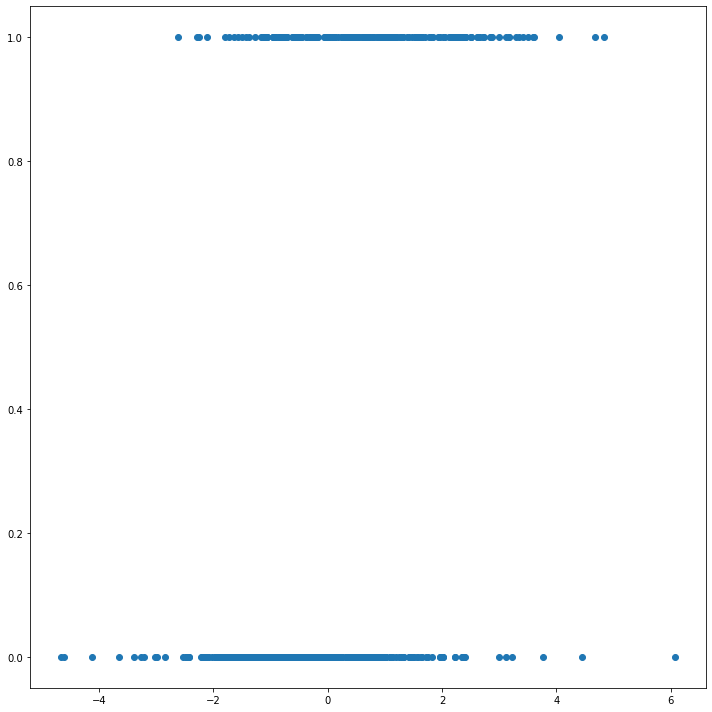

In [15]:
pca_1d = PCA(n_components=1)
pca_1d.fit(X_scaled_train)
plt.scatter(
    pca_1d.transform(X_scaled_train),
    y_scaled_train
)

In [16]:
X_scaled_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
60,-0.547919,-1.154694,-3.572597,-1.288212,-0.692891,-4.060474,-0.507006,-1.041549
618,1.530847,-0.278373,0.666618,0.217261,-0.692891,-0.481351,2.446670,1.425995
346,-0.844885,0.566649,-1.194501,-0.096379,0.027790,-0.417892,0.550035,-0.956462
294,-1.141852,1.255187,-0.987710,-1.288212,-0.692891,-1.280942,-0.658012,2.702312
231,0.639947,0.410164,0.563223,1.032726,2.519781,1.803195,-0.706334,1.085644
...,...,...,...,...,...,...,...,...
71,0.342981,0.566649,-0.263941,0.907270,0.522715,-0.430583,-0.183854,-0.616111
106,-0.844885,-0.779128,2.734528,-1.288212,-0.692891,-1.217483,-0.799958,-0.531023
270,1.827813,-0.622642,0.873409,1.032726,-0.692891,1.727044,2.005732,0.404942
435,-1.141852,0.629244,-3.572597,-1.288212,-0.692891,1.320902,-0.805998,-0.360847


In [17]:
X_scaled_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
60,-0.547919,-1.154694,-3.572597,-1.288212,-0.692891,-4.060474,-0.507006,-1.041549
618,1.530847,-0.278373,0.666618,0.217261,-0.692891,-0.481351,2.446670,1.425995
346,-0.844885,0.566649,-1.194501,-0.096379,0.027790,-0.417892,0.550035,-0.956462
294,-1.141852,1.255187,-0.987710,-1.288212,-0.692891,-1.280942,-0.658012,2.702312
231,0.639947,0.410164,0.563223,1.032726,2.519781,1.803195,-0.706334,1.085644
...,...,...,...,...,...,...,...,...
71,0.342981,0.566649,-0.263941,0.907270,0.522715,-0.430583,-0.183854,-0.616111
106,-0.844885,-0.779128,2.734528,-1.288212,-0.692891,-1.217483,-0.799958,-0.531023
270,1.827813,-0.622642,0.873409,1.032726,-0.692891,1.727044,2.005732,0.404942
435,-1.141852,0.629244,-3.572597,-1.288212,-0.692891,1.320902,-0.805998,-0.360847


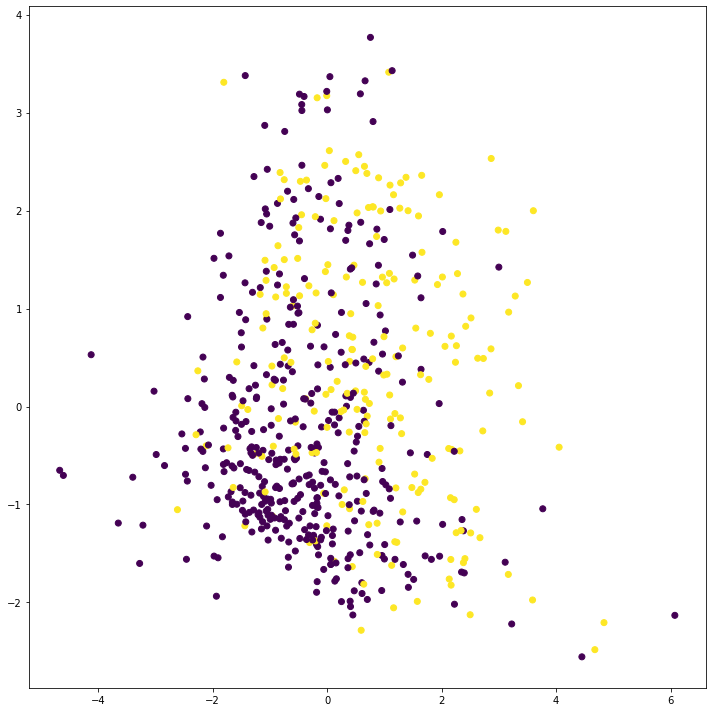

In [22]:
pca_2d = PCA(n_components=2)
pca_2d.fit(X_scaled_train)
pca_2d_results = pca_2d.transform(X_scaled_train)
pca_2d_results = np.transpose(pca_2d_results)
plt.scatter(pca_2d_results[0], pca_2d_results[1], c=y_scaled_train)

***Discussão:*** No PCA com uma componente a separação não indica ser clara o bastante para classificar corretamente os dados por haverem muitos exemplos parecidos com classes diferentes. O mesmo acontece com dois componentes, porém nesse caso é possível que uma terceira dimensão ou outra forma de redução de dimensionalidade (como isomap ou T-SNE) leve a uma separação mais clara dos dados usando apenas duas componentes.

b) Aplicaremos agora a regressão logística utilizando as componentes geradas pelo PCA em três cenários: (i) usando apenas a primeira componente, (ii) usando as 2 primeiras componentes e (iii) usando as 3 primeiras componentes. Gere as métricas acurácia, precisão, recall e AUC da curva ROC.

Discuta os resultados obtidos, indicando qual a contribuição de cada componente e qual número de componentes você utilizaria. 


In [19]:
def train_lr_pca(X, y, n_components):
    pca = PCA(n_components)
    pca.fit(X)

    X = pca.transform(X)

    clf = LogisticRegression(random_state=42, solver='newton-cg')

    print(f'Components: {n_components}')
    train_model(clf, X, y)

for n_components in range(1, 4):
    _ = train_lr_pca(X_scaled, y, n_components)


Components: 1
Model: LogisticRegression
Accuracy: 68.83%
Precision: 38.18%
Recall: 60.00%
ROC AUC: 65.71%

Components: 2
Model: LogisticRegression
Accuracy: 70.78%
Precision: 50.91%
Recall: 60.87%
ROC AUC: 67.93%

Components: 3
Model: LogisticRegression
Accuracy: 72.73%
Precision: 54.55%
Recall: 63.83%
ROC AUC: 70.23%



***Discussão:*** Usaria três componentes por possuir maior ajuste em todas as métricas medidas. A dispersão acima indica que é possível que haja alguma variável que ajude a separar as duas classes usando uma terceira dimensão, o que pode ter causado a melhoria nas métricas em 3 dimensões.

---
## Exercício 5: (2 pontos)

Faremos agora uma análise dos dados usando k-Means.

***Importante:*** para o PCA e k-means funcionarem adequadamente, é essencial fazer a normalização dos preditores, pois cada um deles está em uma escala diferente.

a) Faremos agora uma tentativa de gerar agrupamentos com o k-Means. Você deve fazer o treino do modelo k-Means utilizando apenas os preditores Glucose e BMI do *conjunto de treino*. Em seguida, gere dois scatter plots, utilizando a Glucose e BMI nos eixos. 

No primeiro você deve utilizar o rótulo do grupo gerado pelo k-Means para definir a cor de cada ponto. No segundo, você deve utilizar o rótulo de classe y_train. 

Em seguida, discuta os gráficos gerados. A partir destes 2 gráficos gerados, você acha que seria possível usar o algoritmo de k-means para fazer classificação?


In [74]:
kmeans = KMeans(n_clusters=2, random_state=42)
_ = kmeans.fit(X_scaled_train[['Glucose', 'BMI']])

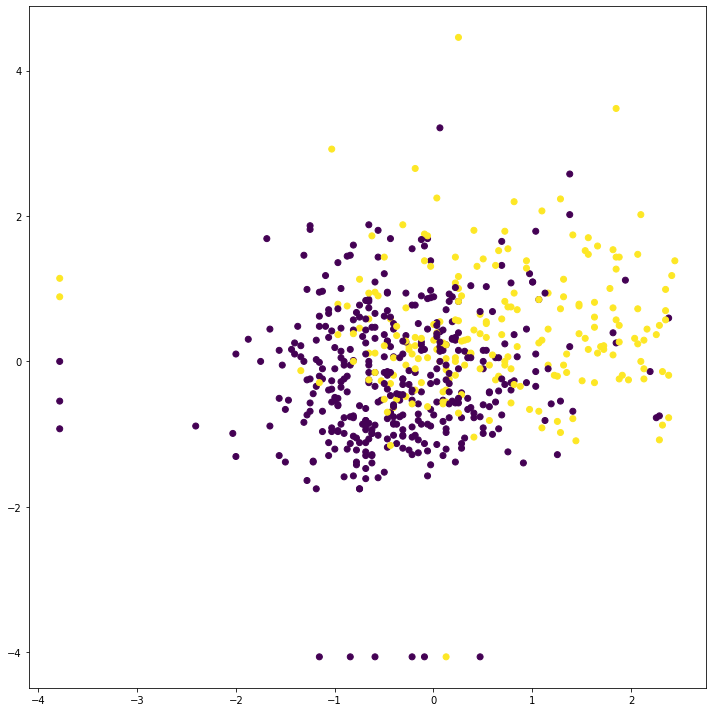

In [76]:
_ = plt.scatter(X_scaled_train['Glucose'], X_scaled_train['BMI'], c=y_scaled_train)

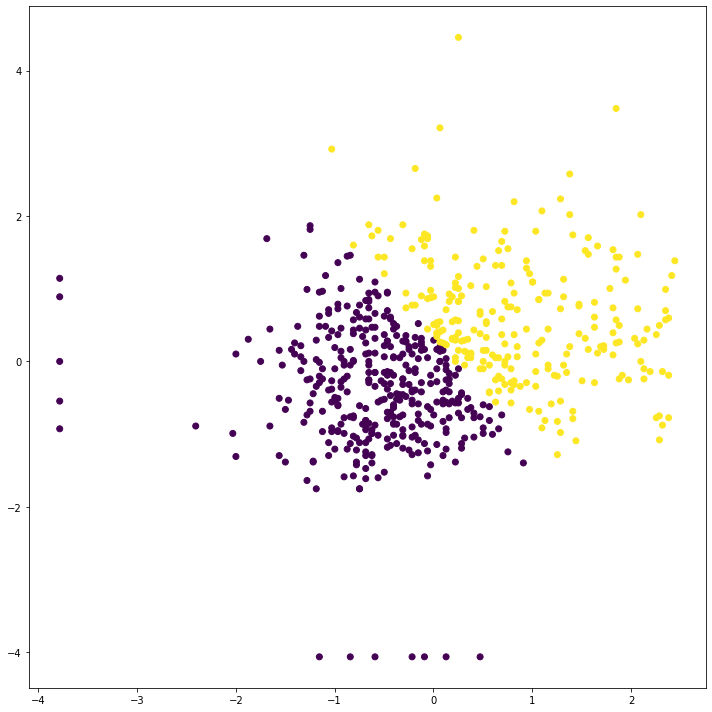

In [77]:
_ = plt.scatter(X_scaled_train['Glucose'], X_scaled_train['BMI'], c=kmeans.labels_)

***Discussão:*** Observando os dois gráficos não parece que é possível fazer classificação nesse caso usando apenas o k-means, já que existem muitos exemplos próximos com classes diferentes.

b) Faça o mesmo procedimento do item a), mas agora treine o modelo do k-Means como todos os preditores. 

Gere os mesmos gráficos com os mesmos eixos e cores do item a) e discuta os resultados para estes novos gráficos, incluindo a possibilidade de realizar classificação com o k-means e sua expectativa dos resultados.


In [78]:
_ = kmeans.fit(X_scaled_train)

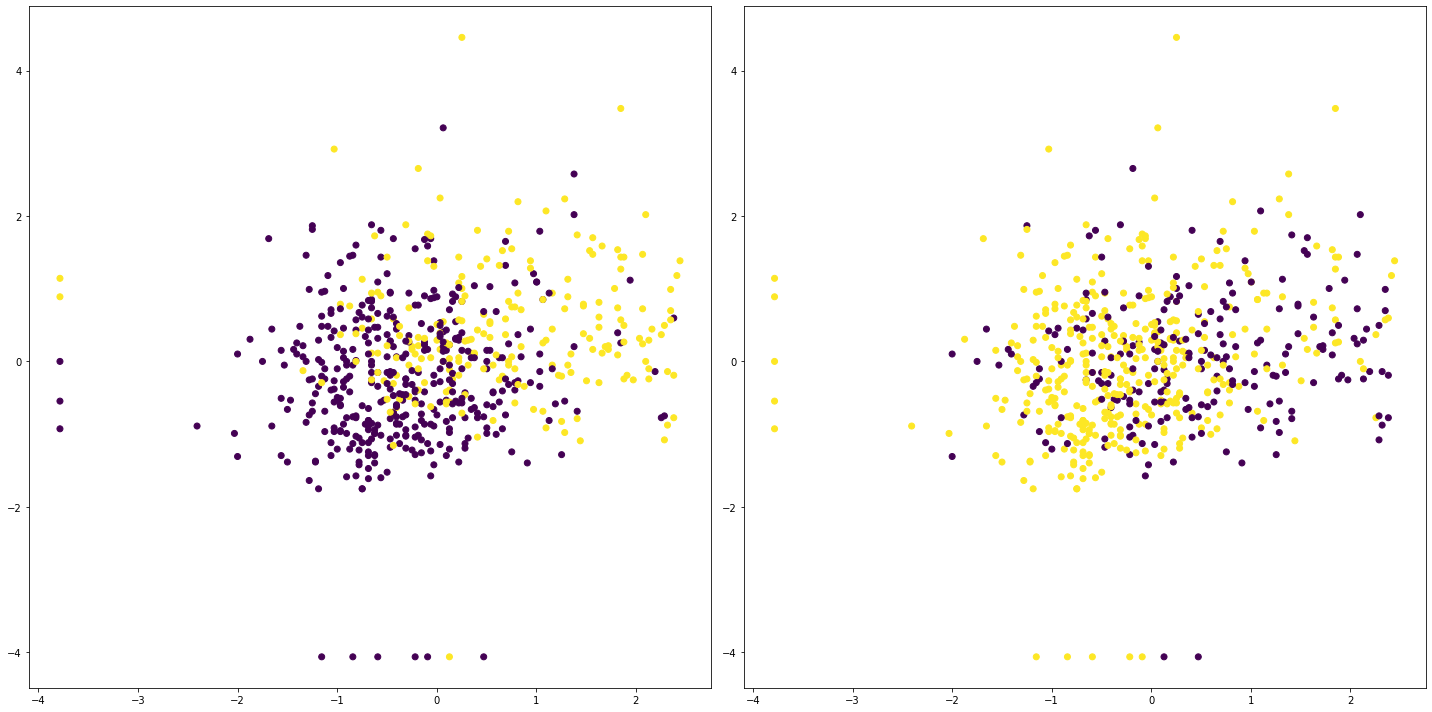

In [104]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].scatter(X_scaled_train['Glucose'], X_scaled_train['BMI'], c=y_scaled_train)
axes[1].scatter(X_scaled_train['Glucose'], X_scaled_train['BMI'], c=kmeans.labels_)
fig.tight_layout()

***Discussão:*** Usando todas as variáveis e observando apenas a dispersão de `Glucose` e `BMI`, classificar usando o k-means parece ser possível, já que as demais variáveis parecem separar os grupos de forma parecida com a distribuição classes dos dados de treino (as cores estão invertidas na segunda dispersão).

c) Faça agora a classificação usando o comando `predict` to k-means.

Treine os 2 modelos (do item a e b) no conjunto de treino e avalie seu desempenho sobre os dados de teste. Gere as métricas acurácia, precisão, recall e AUC da curva ROC.

Em seguida, discuta os resultados obtidos, referenciando os gráficos dos itens a) e b) e comparando com as classificações da Regressão Logística e XGBoost. 

In [94]:
_ = train_model(kmeans, X_scaled, y)

Model: KMeans
Accuracy: 37.01%
Precision: 43.64%
Recall: 26.67%
ROC AUC: 39.11%



***Discussão:***

```
Model: LogisticRegression
Accuracy: 74.68%
Precision: 67.27%
Recall: 63.79%
ROC AUC: 72.52%
```

```
Model: XGBClassifier
Accuracy: 68.18%
Precision: 67.27%
Recall: 54.41%
ROC AUC: 66.74%
```

As métricas são significativamente inferiores em todos os casos para o k-means.

Um possível motivo para essa diferença é que ao treinar o algoritmo com todas as variáveis mas comparar os dois modelos usando apenas uma visualização usando `Glucose` e `BMI` (efetivamente ignorando a informação trazida pelas outras variáveis durante o treino), surge a ilusão que as duas dispersões separam as classes da mesma forma, mas como as classes dependem das outras variáveis, as classes reais se tornam muito diferentes das predições feitas pelo k-means, resultando no baixo ajuste.

Uma alternativa mais adequada para usar o k-means com apenas duas variáveis sem ignorar as outras seria fazer PCA (ou outra técnica de redução de dimensionalidade) para transformar o conjunto de dados e comparar o resultado com o dos modelos treinados também com dimensões reduzidas.